In [3]:
import os

# Biopython
import Bio
from Bio import SeqIO
from Bio import Entrez

# some Python standard lib
import gzip
import random

# python modules for data analysis
import numpy as np
import scipy
import pandas as pd
import networkx as nx

# plotting of data
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIWWW, NCBIXML

/opt/anaconda3/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [4]:
df = pd.read_csv("custom_blast_results.csv", header=None)
df.columns = ["query_id", "subject_id", "percent_identity", "alignment_length", "evalue", "scientific_name"]
df

query_id                        subject_id  percent_identity  \
0        seq_0  Staphylococcus_aureus_chromosome            88.161   
1        seq_0  Staphylococcus_aureus_chromosome            88.161   
2        seq_0  Staphylococcus_aureus_chromosome            88.161   
3        seq_0  Staphylococcus_aureus_chromosome            88.161   
4        seq_0  Staphylococcus_aureus_chromosome            88.098   
...        ...                               ...               ...   
32473  seq_778  Staphylococcus_aureus_chromosome            81.575   
32474  seq_778  Staphylococcus_aureus_chromosome            81.606   
32475  seq_778  Staphylococcus_aureus_chromosome            81.606   
32476  seq_778  Staphylococcus_aureus_chromosome            81.606   
32477  seq_778  Staphylococcus_aureus_chromosome            81.370   

       alignment_length  evalue  scientific_name  
0                  1588     0.0              NaN  
1                  1588     0.0              NaN  
2                  1588     0.0              NaN  
3                  1588     0.0              NaN  
4                  1588     0.0              NaN  
...                 ...     ...              ...  
32473              1460     0.0              NaN  
32474              1457     0.0              NaN  
32475              1457     0.0              NaN  
32476              1457     0.0              NaN  
32477              1460     0.0              NaN  

[32478 rows x 6 columns]

In [5]:
query_id_mapping = {
    "Staphylococcus_aureus_chromosome": "Staphylococcus aureus",
    "Listeria_monocytogenes_complete_genome": "Listeria monocytogenes",
    "Enterococcus_faecalis_complete_genome": "Enterococcus faecalis",
    "Pseudomonas_aeruginosa_complete_genome": "Pseudomonas aeruginosa",
    "Salmonella_enterica_complete_genome": "Salmonella enterica",
    "Escherichia_coli_chromosome": "Escherichia coli",
    "BS.pilon.polished.v3.ST170922": "Bacillus subtilis"
}

df["subject_id"] = df["subject_id"].replace(query_id_mapping)

df

query_id             subject_id  percent_identity  alignment_length  \
0        seq_0  Staphylococcus aureus            88.161              1588   
1        seq_0  Staphylococcus aureus            88.161              1588   
2        seq_0  Staphylococcus aureus            88.161              1588   
3        seq_0  Staphylococcus aureus            88.161              1588   
4        seq_0  Staphylococcus aureus            88.098              1588   
...        ...                    ...               ...               ...   
32473  seq_778  Staphylococcus aureus            81.575              1460   
32474  seq_778  Staphylococcus aureus            81.606              1457   
32475  seq_778  Staphylococcus aureus            81.606              1457   
32476  seq_778  Staphylococcus aureus            81.606              1457   
32477  seq_778  Staphylococcus aureus            81.370              1460   

       evalue  scientific_name  
0         0.0              NaN  
1         0.0              NaN  
2         0.0              NaN  
3         0.0              NaN  
4         0.0              NaN  
...       ...              ...  
32473     0.0              NaN  
32474     0.0              NaN  
32475     0.0              NaN  
32476     0.0              NaN  
32477     0.0              NaN  

[32478 rows x 6 columns]

In [9]:
unique_species = df["subject_id"].unique()
print(unique_species) 

['Staphylococcus aureus' 'Bacillus subtilis' 'Listeria monocytogenes'
 'Enterococcus faecalis' 'Pseudomonas aeruginosa' 'Salmonella enterica'
 'Escherichia coli']


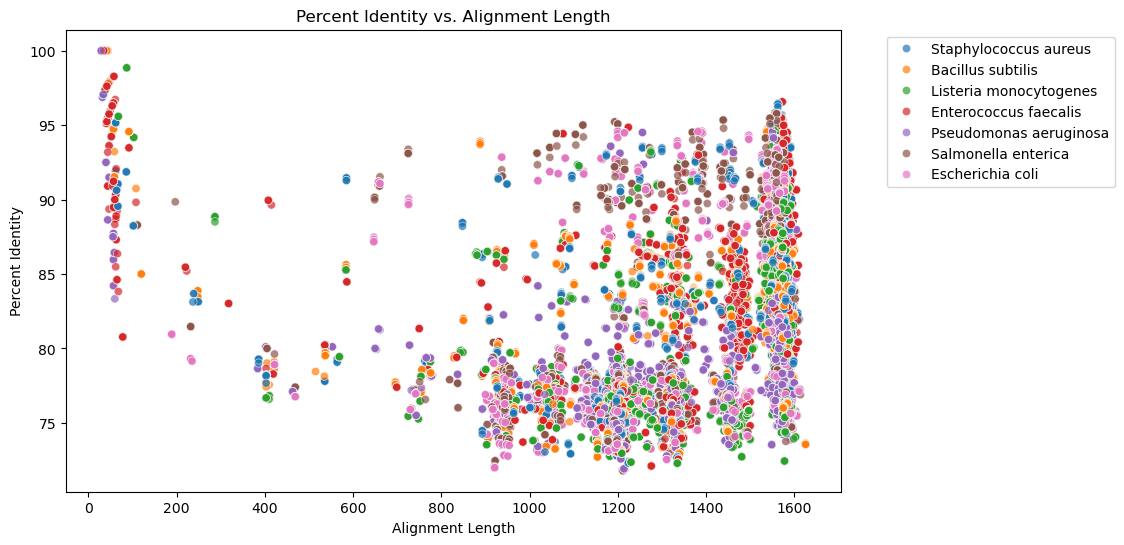

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="alignment_length", y="percent_identity", hue = "subject_id",  alpha=0.7)
plt.xlabel("Alignment Length")
plt.ylabel("Percent Identity")
plt.title("Percent Identity vs. Alignment Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_31436/776282073.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hit_counts, x="num_hits", y="organism", palette="viridis")


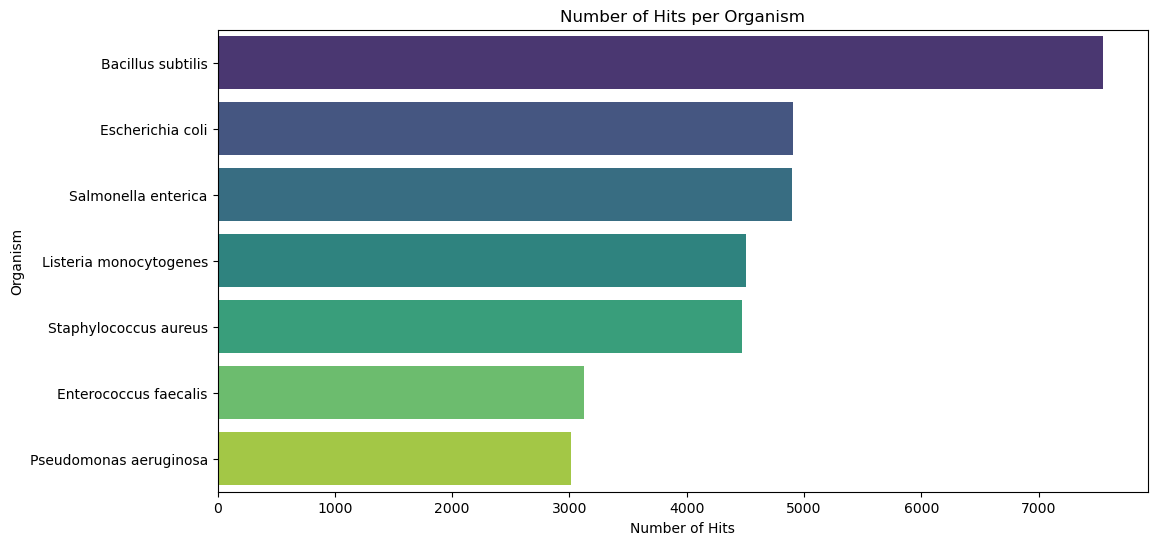

In [13]:
hit_counts = df.groupby("subject_id")["query_id"].count().reset_index()
hit_counts.columns = ["organism", "num_hits"]

# Sort by number of hits
hit_counts = hit_counts.sort_values(by="num_hits", ascending=False).head(20)  # Show top 20

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=hit_counts, x="num_hits", y="organism", palette="viridis")
plt.xlabel("Number of Hits")
plt.ylabel("Organism")
plt.title("Number of Hits per Organism")
plt.show()

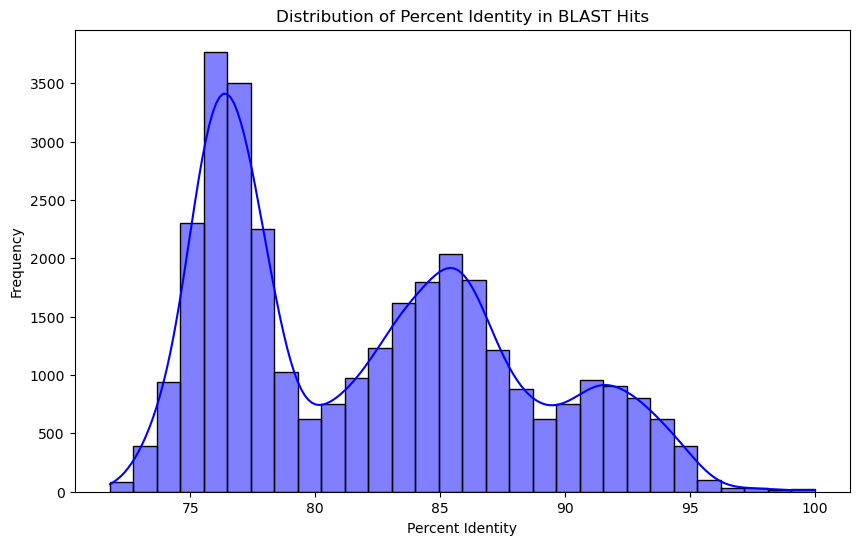

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df["percent_identity"], bins=30, kde=True, color="blue")
plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Distribution of Percent Identity in BLAST Hits")
plt.show()


In [17]:
df["percent_identity"] = pd.to_numeric(df["percent_identity"])
df_sorted = df.sort_values(by="percent_identity", ascending=False)
df_sorted
#Histograms for percent identity and alignment lenght and use the table with all of them
#Count the number of times a species occures
#Add false species to the custom db
#Blast against nt_prok
#minmap2 and analyse the coverge

query_id              subject_id  percent_identity  alignment_length  \
11933  seq_285       Bacillus subtilis           100.000                42   
11934  seq_285       Bacillus subtilis           100.000                42   
5378   seq_129   Enterococcus faecalis           100.000                44   
5377   seq_129   Enterococcus faecalis           100.000                44   
15507  seq_369  Pseudomonas aeruginosa           100.000                29   
...        ...                     ...               ...               ...   
1032    seq_23     Salmonella enterica            71.782              1212   
1030    seq_23     Salmonella enterica            71.782              1212   
1029    seq_23     Salmonella enterica            71.782              1212   
1028    seq_23     Salmonella enterica            71.782              1212   
1027    seq_23     Salmonella enterica            71.782              1212   

             evalue  scientific_name  
11933  1.300000e-13              NaN  
11934  1.300000e-13              NaN  
5378   1.020000e-14              NaN  
5377   1.020000e-14              NaN  
15507  2.210000e-06              NaN  
...             ...              ...  
1032   2.000000e-66              NaN  
1030   2.000000e-66              NaN  
1029   2.000000e-66              NaN  
1028   2.000000e-66              NaN  
1027   2.000000e-66              NaN  

[32478 rows x 6 columns]

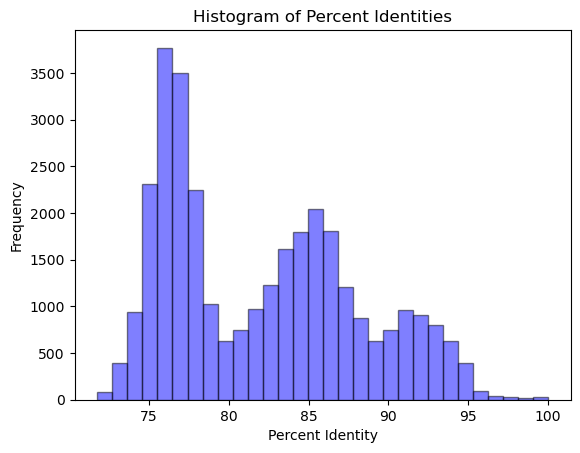

In [19]:
plt.hist(df["percent_identity"], bins=30, color="blue", edgecolor="black", alpha=0.5)


plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Histogram of Percent Identities")


plt.show()

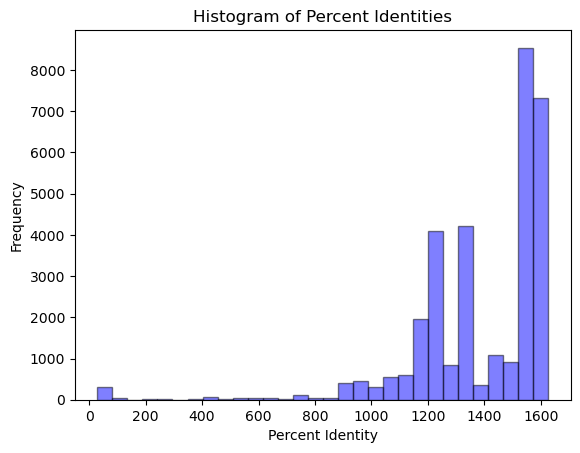

In [21]:
plt.hist(df["alignment_length"], bins=30, color="blue", edgecolor="black", alpha=0.5)


plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Histogram of Percent Identities")


plt.show()

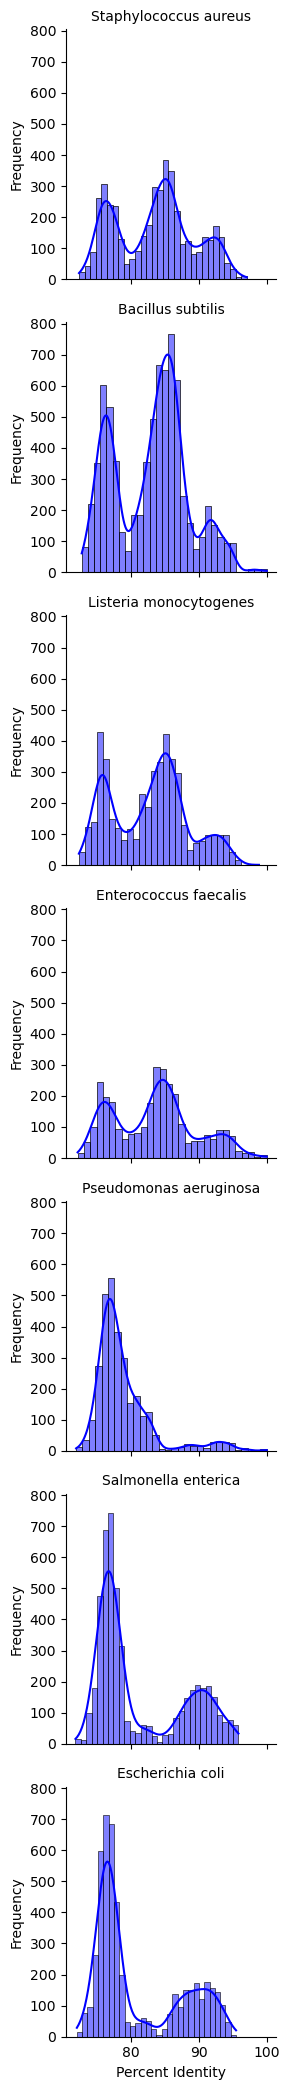

In [23]:
g = sns.FacetGrid(df, col="subject_id", col_wrap=1, sharex=True, sharey=True)
g.map(sns.histplot, "percent_identity", bins=30, kde=True, color="blue")


#do the density for the histograms and for lenghts 



# Add titles and adjust layout
g.set_axis_labels("Percent Identity", "Frequency")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

In [25]:
df_unique_subjects = df_sorted.drop_duplicates(subset="subject_id", keep="first")
df_unique_subjects

query_id              subject_id  percent_identity  alignment_length  \
11933  seq_285       Bacillus subtilis           100.000                42   
5378   seq_129   Enterococcus faecalis           100.000                44   
15507  seq_369  Pseudomonas aeruginosa           100.000                29   
30809  seq_740  Listeria monocytogenes            98.851                87   
15547  seq_369   Staphylococcus aureus            97.059                34   
18674  seq_446     Salmonella enterica            95.825              1557   
11294  seq_271        Escherichia coli            95.475              1547   

             evalue  scientific_name  
11933  1.300000e-13              NaN  
5378   1.020000e-14              NaN  
15507  2.210000e-06              NaN  
30809  5.730000e-37              NaN  
15547  1.710000e-07              NaN  
18674  0.000000e+00              NaN  
11294  0.000000e+00              NaN

In [47]:
df["percent_identity"] = pd.to_numeric(df["percent_identity"], errors="coerce")
df["alignment_length"] = pd.to_numeric(df["alignment_length"], errors="coerce")


filtered_df = df[(df["percent_identity"] >= 93) & (df["alignment_length"] >= 1500)]
filtered_df

query_id              subject_id  percent_identity  alignment_length  \
44       seq_1     Salmonella enterica            93.509              1556   
45       seq_1     Salmonella enterica            93.509              1556   
46       seq_1     Salmonella enterica            93.509              1556   
47       seq_1     Salmonella enterica            93.509              1556   
48       seq_1     Salmonella enterica            93.509              1556   
...        ...                     ...               ...               ...   
32188  seq_772  Pseudomonas aeruginosa            94.194              1550   
32189  seq_772  Pseudomonas aeruginosa            94.140              1553   
32190  seq_772  Pseudomonas aeruginosa            94.140              1553   
32191  seq_772  Pseudomonas aeruginosa            94.140              1553   
32364  seq_776     Salmonella enterica            93.112              1539   

       evalue  scientific_name  
44        0.0              NaN  
45        0.0              NaN  
46        0.0              NaN  
47        0.0              NaN  
48        0.0              NaN  
...       ...              ...  
32188     0.0              NaN  
32189     0.0              NaN  
32190     0.0              NaN  
32191     0.0              NaN  
32364     0.0              NaN  

[1131 rows x 6 columns]

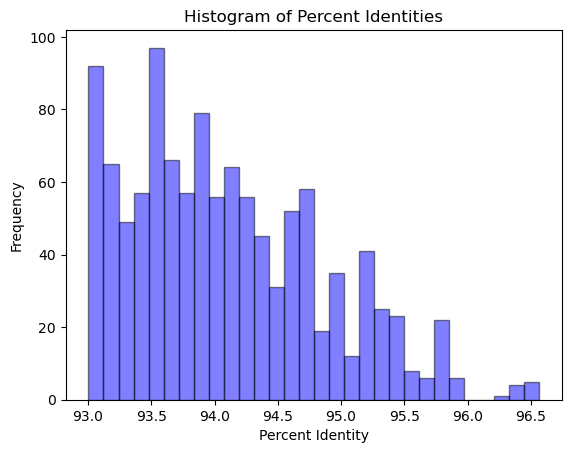

In [49]:
plt.hist(filtered_df["percent_identity"], bins=30, color="blue", edgecolor="black", alpha=0.5)


plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Histogram of Percent Identities")


plt.show()

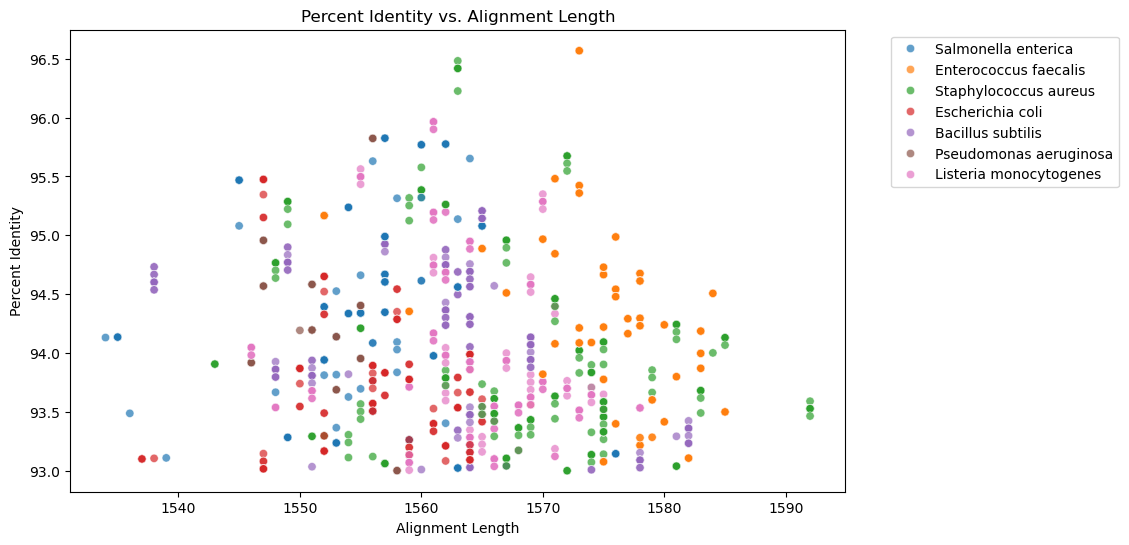

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x="alignment_length", y="percent_identity", hue = "subject_id",  alpha=0.7)
plt.xlabel("Alignment Length")
plt.ylabel("Percent Identity")
plt.title("Percent Identity vs. Alignment Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [85]:
filtered_df.to_csv("ANA.csv", index=False)

In [75]:
df_unique = filtered_df.sort_values(by=["percent_identity"], ascending=False).drop_duplicates(subset=["query_id"], keep="first")
df_unique

query_id              subject_id  percent_identity  alignment_length  \
23497  seq_562   Enterococcus faecalis            96.567              1573   
31514  seq_757   Staphylococcus aureus            96.481              1563   
11247  seq_270  Listeria monocytogenes            95.964              1561   
18671  seq_446     Salmonella enterica            95.825              1557   
12408  seq_296  Pseudomonas aeruginosa            95.823              1556   
...        ...                     ...               ...               ...   
24552  seq_588       Bacillus subtilis            93.031              1564   
25940  seq_623     Salmonella enterica            93.026              1563   
22376  seq_535       Bacillus subtilis            93.013              1560   
6071   seq_146       Bacillus subtilis            93.011              1574   
29846  seq_716  Pseudomonas aeruginosa            93.004              1558   

       evalue  scientific_name  
23497     0.0              NaN  
31514     0.0              NaN  
11247     0.0              NaN  
18671     0.0              NaN  
12408     0.0              NaN  
...       ...              ...  
24552     0.0              NaN  
25940     0.0              NaN  
22376     0.0              NaN  
6071      0.0              NaN  
29846     0.0              NaN  

[187 rows x 6 columns]

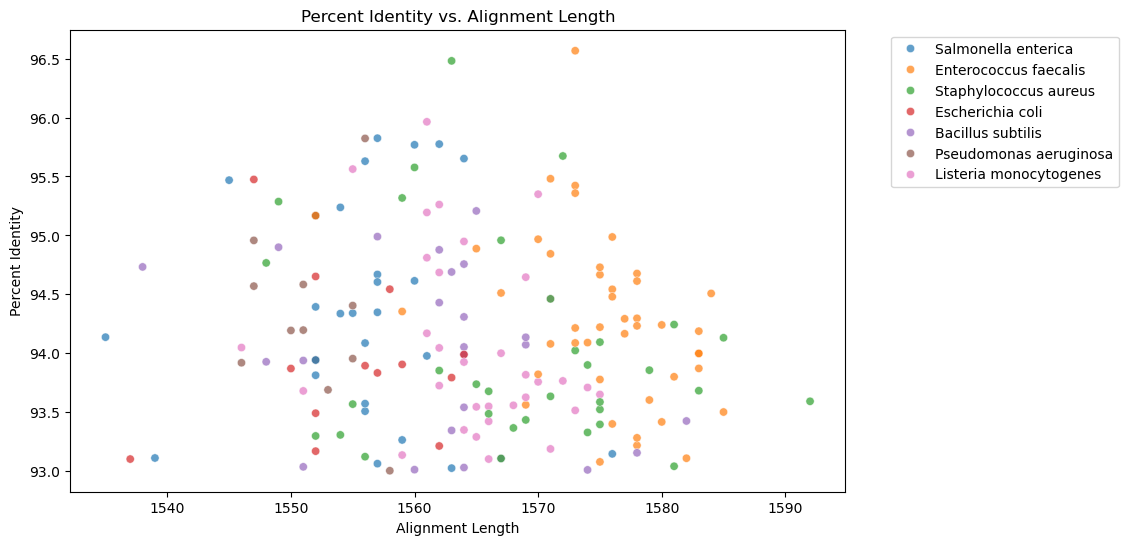

In [87]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data= df_unique, x="alignment_length", y="percent_identity", hue = "subject_id",  alpha=0.7)
plt.xlabel("Alignment Length")
plt.ylabel("Percent Identity")
plt.title("Percent Identity vs. Alignment Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [96]:
df_nt = pd.read_csv("ntprok_blast_results.csv", header=None)
df_nt.columns = ["query_id", "subject_id", "percent_identity", "alignment_length", "evalue", "scientific_name"]
df_nt

query_id                     subject_id  percent_identity  \
0        seq_0   gi|2580180446|gb|CP134532.1|            88.287   
1        seq_0   gi|2580180446|gb|CP134532.1|            88.098   
2        seq_0   gi|2580180446|gb|CP134532.1|            88.098   
3        seq_0   gi|2580180446|gb|CP134532.1|            88.098   
4        seq_0   gi|2580180446|gb|CP134532.1|            87.909   
...        ...                            ...               ...   
93092  seq_778  gi|1654258058|emb|LR594051.1|            87.773   
93093  seq_778   gi|1519052672|gb|CP033787.1|            87.838   
93094  seq_778   gi|1519052672|gb|CP033787.1|            87.773   
93095  seq_778   gi|1519052672|gb|CP033787.1|            87.773   
93096  seq_778   gi|1519052672|gb|CP033787.1|            87.709   

       alignment_length  evalue  scientific_name  
0                  1588     0.0              NaN  
1                  1588     0.0              NaN  
2                  1588     0.0              NaN  
3                  1588     0.0              NaN  
4                  1588     0.0              NaN  
...                 ...     ...              ...  
93092              1554     0.0              NaN  
93093              1554     0.0              NaN  
93094              1554     0.0              NaN  
93095              1554     0.0              NaN  
93096              1554     0.0              NaN  

[93097 rows x 6 columns]

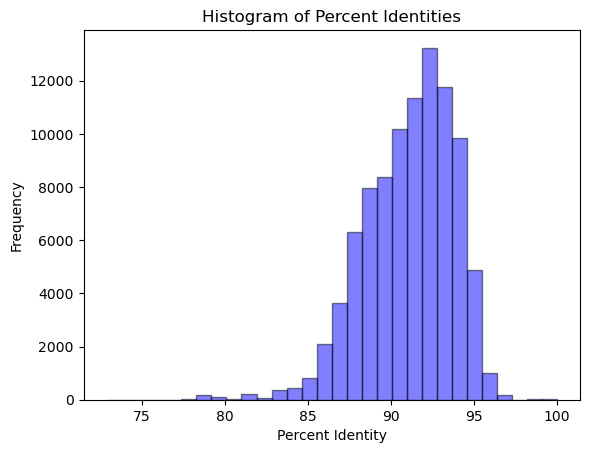

In [98]:
plt.hist(df_nt["percent_identity"], bins=30, color="blue", edgecolor="black", alpha=0.5)


plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Histogram of Percent Identities")


plt.show()

In [100]:
df_nt["percent_identity"] = pd.to_numeric(df_nt["percent_identity"])
df_nt_sorted = df_nt.sort_values(by="percent_identity", ascending=False)
df_nt_sorted

query_id                    subject_id  percent_identity  \
50245  seq_419  gi|1777404735|gb|CP045918.1|           100.000   
88697  seq_740  gi|1209185526|gb|MF372566.1|           100.000   
89495  seq_747  gi|1785218386|gb|CP044298.1|           100.000   
44377  seq_369  gi|2320656653|gb|CP083359.1|           100.000   
28132  seq_234  gi|1747269349|gb|CP043919.1|           100.000   
...        ...                           ...               ...   
50324  seq_420  gi|1777404735|gb|CP045918.1|            74.828   
24002  seq_199  gi|1785206035|gb|CP044291.1|            74.377   
92574  seq_774  gi|1777404735|gb|CP045918.1|            73.581   
24003  seq_199  gi|1785206035|gb|CP044291.1|            73.522   
55803  seq_467  gi|1777404735|gb|CP045918.1|            72.863   

       alignment_length         evalue  scientific_name  
50245                59   3.270000e-19              NaN  
88697                69   8.750000e-25              NaN  
89495                28   5.500000e-02              NaN  
44377                29   1.500000e-02              NaN  
28132                37   5.530000e-07              NaN  
...                 ...            ...              ...  
50324               437   1.390000e-37              NaN  
24002              1604  4.550000e-137              NaN  
92574               458   6.810000e-31              NaN  
24003              1590  1.320000e-107              NaN  
55803               468   1.480000e-27              NaN  

[93097 rows x 6 columns]

In [104]:
df_nt["percent_identity"] = pd.to_numeric(df_nt["percent_identity"], errors="coerce")
df_nt["alignment_length"] = pd.to_numeric(df_nt["alignment_length"], errors="coerce")


ft_nt = df_nt[(df_nt["percent_identity"] >= 90) & (df_nt["alignment_length"] >= 1500)]
ft_nt

query_id                    subject_id  percent_identity  \
117      seq_1  gi|1633248057|gb|CP039757.1|            93.573   
118      seq_1  gi|1633248057|gb|CP039757.1|            93.509   
119      seq_1  gi|1633248057|gb|CP039757.1|            93.509   
120      seq_1  gi|1633248057|gb|CP039757.1|            93.509   
121      seq_1  gi|1633248057|gb|CP039757.1|            93.509   
...        ...                           ...               ...   
93018  seq_777  gi|2705586323|gb|CP149507.1|            91.790   
93019  seq_777  gi|2705586323|gb|CP149507.1|            91.790   
93020  seq_777  gi|2705586323|gb|CP149507.1|            91.790   
93021  seq_777  gi|2705586323|gb|CP149507.1|            91.790   
93022  seq_777  gi|2705586323|gb|CP149507.1|            91.090   

       alignment_length  evalue  scientific_name  
117                1556     0.0              NaN  
118                1556     0.0              NaN  
119                1556     0.0              NaN  
120                1556     0.0              NaN  
121                1556     0.0              NaN  
...                 ...     ...              ...  
93018              1559     0.0              NaN  
93019              1559     0.0              NaN  
93020              1559     0.0              NaN  
93021              1559     0.0              NaN  
93022              1560     0.0              NaN  

[53215 rows x 6 columns]

In [106]:
df_unique_subjects_nt = ft_nt.drop_duplicates(subset="subject_id", keep="first")
df_unique_subjects_nt

query_id                    subject_id  percent_identity  \
117      seq_1  gi|1633248057|gb|CP039757.1|            93.573   
124      seq_1  gi|2450597366|gb|CP117322.1|            93.573   
131      seq_1  gi|1947666188|gb|CP065890.1|            93.573   
138      seq_1  gi|2094623487|gb|CP077664.1|            93.569   
145      seq_1  gi|1828417065|gb|CP050757.1|            93.509   
...        ...                           ...               ...   
92365  seq_772  gi|1854660178|gb|CP050326.1|            94.194   
92369  seq_772  gi|1854649030|gb|CP050325.1|            94.140   
92373  seq_772  gi|1854637997|gb|CP050324.1|            94.194   
92377  seq_772  gi|1854615033|gb|CP050322.1|            94.194   
92381  seq_772  gi|1854497669|gb|CP054572.1|            94.194   

       alignment_length  evalue  scientific_name  
117                1556     0.0              NaN  
124                1556     0.0              NaN  
131                1556     0.0              NaN  
138                1555     0.0              NaN  
145                1556     0.0              NaN  
...                 ...     ...              ...  
92365              1550     0.0              NaN  
92369              1553     0.0              NaN  
92373              1550     0.0              NaN  
92377              1550     0.0              NaN  
92381              1550     0.0              NaN  

[2219 rows x 6 columns]

In [108]:
ft_nt["percent_identity"] = pd.to_numeric(df_nt["percent_identity"])
ft_nt_sorted = ft_nt.sort_values(by="percent_identity", ascending=False)
ft_nt_sorted

/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_1491/3355751284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_nt["percent_identity"] = pd.to_numeric(df_nt["percent_identity"])


query_id                     subject_id  percent_identity  \
67594  seq_562  gi|1963810764|emb|LR962620.1|            96.631   
67586  seq_562  gi|1963811865|emb|LR962708.1|            96.631   
67554  seq_562  gi|1654258058|emb|LR594051.1|            96.631   
67562  seq_562   gi|2755869867|gb|CP095333.1|            96.631   
67583  seq_562  gi|2082818396|emb|OD940440.2|            96.631   
...        ...                            ...               ...   
77128  seq_645   gi|2702829513|gb|CP148286.1|            90.000   
38960  seq_324   gi|1836426080|gb|CP049981.1|            90.000   
38946  seq_324   gi|1836440065|gb|CP049986.1|            90.000   
38924  seq_324   gi|2852901372|gb|CP173281.1|            90.000   
24349  seq_202   gi|2646573844|gb|CP141478.1|            90.000   

       alignment_length  evalue  scientific_name  
67594              1573     0.0              NaN  
67586              1573     0.0              NaN  
67554              1573     0.0              NaN  
67562              1573     0.0              NaN  
67583              1573     0.0              NaN  
...                 ...     ...              ...  
77128              1570     0.0              NaN  
38960              1580     0.0              NaN  
38946              1580     0.0              NaN  
38924              1580     0.0              NaN  
24349              1570     0.0              NaN  

[53215 rows x 6 columns]